<a href="https://colab.research.google.com/github/DLPietro/igaming-analytics-case-study/blob/main/igaming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

np.random.seed(69)

# Parametri
n_players = 1200
n_weeks = 4
n_sessions = 10000 * n_weeks
avg_session = n_sessions / n_players
start = datetime(2025, 9, 1)
end = datetime(2025, 9, 28)

# Sessioni per player, Poisson
session_counts = np.random.poisson(lam=avg_session, size=n_players)

# Bilancia total session count a n_sessions
current_total = session_counts.sum()
diff = n_sessions - current_total
if diff > 0:
    idx = np.random.choice(n_players, size=diff, replace=True)
    session_counts[idx] += 1
elif diff < 0:
    idx = np.random.choice(n_players, size=-diff, replace=True)
    session_counts[idx] -= 1

data = []

for player_idx in range(n_players):
    player_id = f'P{player_idx:04d}'
    player_sessions = session_counts[player_idx]
    first_deposit_made = False

    for i in range(player_sessions):
        # Decadimento dell'attività nelle settimane successive
        week_offset = np.random.choice([0, 1, 2, 3], p=[0.65, 0.20, 0.10, 0.05])
        day_in_week = np.random.randint(0, 7)
        delta_days = week_offset * 7 + day_in_week
        session_start = start + timedelta(days=int(delta_days), hours=np.random.randint(0, 24), minutes=np.random.randint(0, 60))

        # Durata sessione, esponenziale con aumento nei weekend
        duration = np.random.exponential(30)
        day_of_week = session_start.weekday()
        weekend_boost = 1.0
        if day_of_week >= 5:
            weekend_boost = np.random.uniform(1.1, 1.6)
            duration *= weekend_boost

        session_end = session_start + timedelta(minutes=duration)

        device = np.random.choice(['Mobile', 'Computer', 'Tablet'], p=[0.5, 0.4, 0.1])
        game_type = np.random.choice(['Slot', 'Blackjack', 'Poker', 'Roulette'], p=[0.4, 0.1, 0.2, 0.3])

        base_promo_weights = np.array([0.3, 0.1, 0.1, 0.5])
        if day_of_week == 0:
            base_promo_weights = np.array([0.4, 0.1, 0.1, 0.4])
        elif day_of_week >= 5:
            base_promo_weights = np.array([0.3, 0.2, 0.1, 0.4])
        promo = np.random.choice(['NEWUSER10', 'CASINO20', 'POKER15', None], p=base_promo_weights)

        deposit_prob = 0.8 if promo else 0.4
        if day_of_week >= 5:
            deposit_prob = min(deposit_prob * 1.3, 1.0)

        # Riduci probabilità deposito nelle settimane successive
        if week_offset > 0:
            deposit_prob *= (0.5 ** week_offset)

        if not first_deposit_made:
            deposit_prob = max(deposit_prob, 0.7)

        deposit = np.random.exponential(100) if np.random.rand() < deposit_prob else 0
        if deposit > 0:
            first_deposit_made = True

        bet = np.random.uniform(10, 500)
        rtp_map = {'Slot': 0.92, 'Blackjack': 0.98, 'Poker': 0.97, 'Roulette': 0.95}
        rtp = np.random.normal(rtp_map[game_type], 0.02)
        rtp = min(max(rtp, 0.85), 1.05)
        payout = bet * rtp
        ggr = bet - payout

        bonus = 0
        if promo == 'NEWUSER10':
            bonus = 10
        elif promo == 'CASINO20':
            bonus = 20
        elif promo == 'POKER15':
            bonus = 15
        ngr = max(ggr - bonus, 0)

        data.append({
            'player_id': player_id,
            'session_start': session_start,
            'session_end': session_end,
            'session_duration_min': round(duration, 2),
            'device': device,
            'game_type': game_type,
            'promo_code': promo,
            'deposit_amount': round(deposit, 2),
            'bet_amount': round(bet, 2),
            'payout_amount': round(payout, 2),
            'rtp': round(rtp, 3),
            'ggr': round(ggr, 2),
            'ngr': round(ngr, 2)
        })

df = pd.DataFrame(data)
df.to_csv('player_sessions.csv', index=False)

print(f"✅ {len(df)} simulated sessions generated from {n_players} unique players ({len(df)/n_players:.1f} sessions/player avg).")
session_counts_per_player = df['player_id'].value_counts()
print("\n📊 Session count per player (sample):")
print(session_counts_per_player.head(10))
print(f"\nMean sessions per player: {session_counts_per_player.mean():.2f}")
print(f"Std dev: {session_counts_per_player.std():.2f}")
print(f"Min: {session_counts_per_player.min()}, Max: {session_counts_per_player.max()}")

✅ 39978 simulated sessions generated from 1200 unique players (33.3 sessions/player avg).

📊 Session count per player (sample):
player_id
P1168    56
P0676    53
P1054    51
P0576    51
P1199    50
P0249    50
P0699    49
P0493    49
P0172    49
P0957    49
Name: count, dtype: int64

Mean sessions per player: 33.31
Std dev: 5.81
Min: 15, Max: 56


In [ ]:
### Daily report: from the data generator.py file, generated a daily report with summarised stats for key factor analysis

# Step 1: importing libraries, only pandas for the dataframe needed
import pandas as pd

df = pd.read_csv('player_sessions.csv')                                  # Reading .csv file of data generator
df['session_start'] = pd.to_datetime(df['session_start'])                # selecting session start
df['day'] = df['session_start'].dt.date                                  # analysing single day from the data file

# Step 2: Calculating daily key factors, aggregating them per player
daily_report = df.groupby('day').agg(                                          # adding column of this new data file
    total_sessions=('player_id', 'count'),
    unique_players=('player_id', 'nunique'),
    total_deposit=('deposit_amount', 'sum'),
    total_bet=('bet_amount', 'sum'),
    total_payout=('payout_amount', 'sum'),
    total_ggr=('ggr', 'sum'),
    total_ngr=('ngr', 'sum'),
    avg_session_duration=('session_duration_min', 'mean'),
    avg_rtp=('rtp', 'mean')
).round(2).reset_index()

# Step 3: Adding KPIs
daily_report['ggr_per_session'] = daily_report['total_ggr'] / daily_report['total_sessions']
daily_report['ngr_per_player'] = daily_report['total_ngr'] / daily_report['unique_players']
daily_report['conversion_rate'] = (daily_report['total_deposit'] > 0).sum() / len(df) * 100         # Percentage players who make a deposit

# Step 4: Saving the report
daily_report.to_csv('daily_kpi_report.csv', index=False)
print("📊 Daily KPI report generated.")

# Step 5: Showing summary
print("\n=== DAILY SUMMARY ===")
print(daily_report[['day', 'unique_players', 'total_sessions', 'total_ngr', 'avg_session_duration', 'avg_rtp']].to_string(index=False))

📊 Daily KPI report generated.

=== DAILY SUMMARY ===
       day  unique_players  total_sessions  total_ngr  avg_session_duration  avg_rtp
2025-09-01            1128            3615   32577.89                 30.76     0.94
2025-09-02            1150            3651   36059.43                 30.61     0.94
2025-09-03            1147            3776   36649.20                 30.55     0.95
2025-09-04            1147            3702   36447.32                 29.36     0.94
2025-09-05            1149            3780   38067.83                 29.96     0.94
2025-09-06            1146            3647   30673.93                 40.02     0.94
2025-09-07            1151            3876   33109.28                 40.36     0.94
2025-09-08             740            1134   10169.30                 31.00     0.94
2025-09-09             743            1139   12119.60                 30.98     0.94
2025-09-10             702            1091   10243.74                 30.59     0.94
2025-09-11  

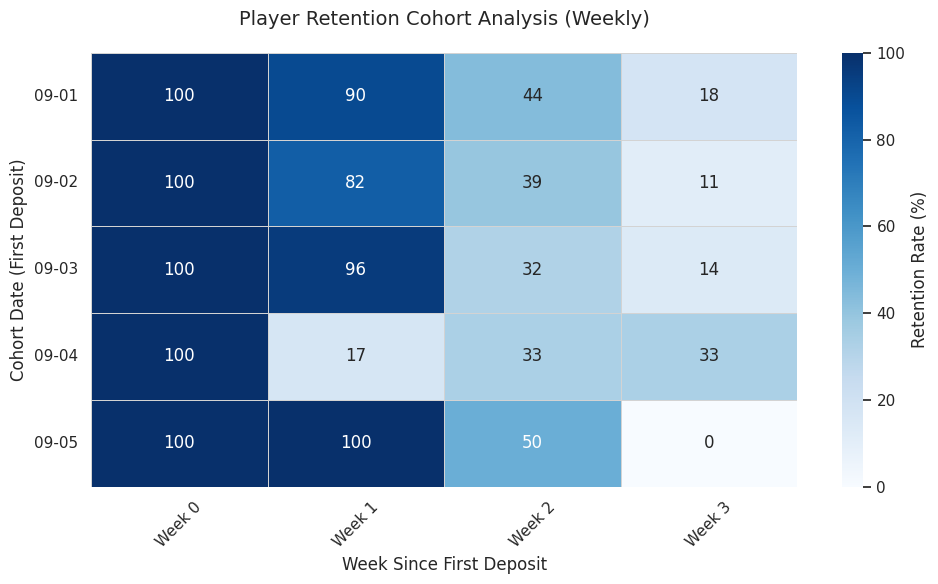

✅ Cohort analysis completed.
📊 Heatmap saved to: cohort_retention_heatmap.png
💾 Matrix saved to: cohort_retention_matrix.csv

📈 Average Retention Rate per Week:
week_diff
0    100.0
1     76.8
2     39.7
3     15.1
dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('player_sessions.csv')
df['session_start'] = pd.to_datetime(df['session_start'])
df['date'] = df['session_start'].dt.date

# Primo deposito per player (data minima con deposito > 0)
first_deposit = df[df['deposit_amount'] > 0].groupby('player_id')['date'].min().reset_index()
first_deposit.columns = ['player_id', 'cohort_date']
df = df.merge(first_deposit, on='player_id', how='left')

# Differenza settimane tra sessione e cohort date
df['week_diff'] = np.floor((df['session_start'] - pd.to_datetime(df['cohort_date'])) / np.timedelta64(1, 'W')).astype(int)

# Filtra sessioni solo da settimana 0 a settimana 3
df = df[(df['week_diff'] >= 0) & (df['week_diff'] < 4)]

# Definisce utenti attivi a settimana x come quelli con almeno una sessione e deposito > 0 in quella settimana
active_sessions = df[df['deposit_amount'] > 0]

cohort_matrix = active_sessions.groupby(['cohort_date', 'week_diff']).agg(
    unique_players=('player_id', 'nunique')
).reset_index()

cohort_pivot = cohort_matrix.pivot_table(
    index='cohort_date',
    columns='week_diff',
    values='unique_players',
    fill_value=0
)

cohort_size = cohort_pivot.iloc[:, 0]
cohort_retention = cohort_pivot.divide(cohort_size, axis=0).round(3) * 100

# Filtra cohort incomplete (che non hanno ancora avuto tempo per arrivare a settimana 3)
today = df['session_start'].max().normalize()
cohort_max_weeks = ((today - pd.to_datetime(cohort_retention.index)) / np.timedelta64(1, 'W')).astype(int)
cohort_retention = cohort_retention[cohort_max_weeks >= 3]
cohort_size = cohort_size[cohort_retention.index]

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

ax = sns.heatmap(
    cohort_retention,
    annot=True, fmt=".0f", cmap="Blues", cbar_kws={'label': 'Retention Rate (%)'},
    linewidths=0.5, linecolor='lightgrey', vmin=0, vmax=100
)

ax.set_title("Player Retention Cohort Analysis (Weekly)", fontsize=14, pad=20)
ax.set_xlabel("Week Since First Deposit")
ax.set_ylabel("Cohort Date (First Deposit)")
ax.set_xticklabels(['Week 0', 'Week 1', 'Week 2', 'Week 3'], rotation=45)
ax.set_yticklabels([pd.to_datetime(d).strftime('%m-%d') for d in cohort_retention.index], rotation=0)

plt.tight_layout()
plt.savefig('cohort_retention_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Salva file csv con matrice retention
cohort_retention.insert(0, 'Cohort Size', cohort_size)
cohort_retention.to_csv('cohort_retention_matrix.csv')

print("✅ Cohort analysis completed.")
print("📊 Heatmap saved to: cohort_retention_heatmap.png")
print("💾 Matrix saved to: cohort_retention_matrix.csv")

print("\n📈 Average Retention Rate per Week:")
retention_avg = cohort_retention.drop(columns='Cohort Size').mean().round(1)
print(retention_avg)

In [ ]:
### CHURN RISK SCORE - PREDICTIVE MACHINE LEARNING MODEL
# Main goal: forecast players with a high risk profile (they can leave the platform next week)
# prevent this risk

# Step 1: Importing new libraries and downloading data
import pandas as pd, numpy as np, joblib, os                    # Joblib: model safer
from sklearn.model_selection import train_test_split        # skitlearn: a library for machine learning, whose functions are train_test_split (divide data into training and test)
from sklearn.linear_model import LogisticRegression         # LogisticRegression: classification model
from sklearn.preprocessing import LabelEncoder              # LabelEncoder: Convert text into numbers, since ML models cannot work with strings
from sklearn.metrics import classification_report, roc_auc_score  # classification_report: performance evaluation with precision, recall, F-score, and support
# roc_auc_score: capacity to distinguish between classes

df = pd.read_csv('player_sessions.csv')
df['session_start'] = pd.to_datetime(df['session_start'])

# Step 2: Analyse info per player
player_features = df.groupby('player_id').agg(
    total_sessions=('player_id', 'count'),
    first_deposit=('deposit_amount', 'first'),           # First Deposit
    avg_session_duration=('session_duration_min', 'mean'),
    has_bonus=('promo_code', lambda x: (x.notna()).any()),  # Whether He used bonuses or not
    main_game_type=('game_type', lambda x: x.mode()[0]),   # THe most played game
    days_active=('session_start', lambda x: (x.max() - x.min()).days)  # THe most active games
).reset_index()

# Step 3: Encoding categorical variables
le = LabelEncoder()                                            # To encode categorical variables
player_features['main_game_type_encoded'] = le.fit_transform(player_features['main_game_type'])

# Step 4: Churn probability definition (based on the observations of the data)
player_features['churn_prob'] = (
    0.1 +  # base
    (player_features['total_sessions'] < 2) * 0.3 +
    (player_features['first_deposit'] < 20) * 0.25 +
    (player_features['days_active'] == 1) * 0.2 +
    (player_features['avg_session_duration'] < 10) * 0.15
)

player_features['is_churned'] = (np.random.random(len(player_features)) < player_features['churn_prob']).astype(int)       # Defined random limit to generate the target
player_features = player_features.drop(columns=['churn_prob'])                            # removing probability column

# Step 4: defining dependent value and independent variables, and the elements for the logistic regression
X = player_features[['total_sessions', 'first_deposit', 'avg_session_duration',
                     'has_bonus', 'main_game_type_encoded', 'days_active']]
y = player_features['is_churned']               # The model splits high risk profiles and not

# Step 5: logistic model and evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = LogisticRegression(class_weight='balanced', max_iter=1000)            # Model Training
model.fit(X_train, y_train)                                                   # measuring the suitability
y_pred = model.predict(X_test)                                                # evaluating the model with the dataset
y_proba = model.predict_proba(X_test)[:, 1]

print("🎯 CHURN PREDICTOR RESULTS")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_proba):.3f}")

# Step 6: saving model with joblib
joblib.dump(model, 'churn_model.pkl')
joblib.dump(list(X.columns), 'feature_names.pkl')
print("\n✅ Model saved to churn_model.pkl")
print("✅ Feature names saved to feature_names.pkl")

# Step 7: Saving Top 100 at-risk players' report
player_features['churn_risk_score'] = model.predict_proba(X)[:, 1]
risk_scores = player_features[['player_id', 'churn_risk_score']].sort_values(by='churn_risk_score', ascending=False)
top_risk = risk_scores.head(100)
top_risk.to_csv('top_churn_risk_players.csv', index=False)
print(f"\n✅ Top 100 at-risk players saved as: top_churn_risk_players.csv")

# EXAMPLE FOR A NEW PLAYER
sample = [[2, 25, 15, False, 0, 1]]  # 2 sessions, 25€ deposit, 15min duration, no bonus, slot, 1 active day
pred = model.predict(sample)[0]
prob = model.predict_proba(sample)[0][1]
print(f"\n🔮 Sample Prediction: Churn Risk = {'HIGH' if pred == 1 else 'LOW'} (Probability: {prob:.2%})")

🎯 CHURN PREDICTOR RESULTS
              precision    recall  f1-score   support

           0       0.87      0.47      0.61       196
           1       0.23      0.68      0.34        44

    accuracy                           0.51       240
   macro avg       0.55      0.58      0.48       240
weighted avg       0.75      0.51      0.56       240

AUC Score: 0.638

✅ Model saved to churn_model.pkl
✅ Feature names saved to feature_names.pkl

✅ Top 100 at-risk players saved as: top_churn_risk_players.csv

🔮 Sample Prediction: Churn Risk = HIGH (Probability: 66.01%)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
